In [25]:
import numpy as np
import pandas as pd
import math as m
from yahoo_fin import options
from datetime import datetime
import yahoo_fin.stock_info as si
import yfinance as yf
import scipy as sp
import matplotlib.pyplot as plt

# Part 1: we detail the process on how to repair the call price surface

We define a global variable equal to today's date

In [426]:
today= datetime.today()
today

datetime.datetime(2023, 11, 8, 15, 58, 33, 144056)

We choose first a stock that pays no dividend. Tesla is liquid and has a wide range of strikes so it is a good choice: furthermore even if options are american on this stock it does not matter since there is no dividend involved

In [427]:
ticker = "TSLA"
S=si.get_live_price(ticker)

In [428]:
S

220.07000732421875

We get the available maturities for the options on that stock

In [429]:
maturities = options.get_expiration_dates(ticker)
maturities

['November 10, 2023',
 'November 17, 2023',
 'November 24, 2023',
 'December 1, 2023',
 'December 8, 2023',
 'December 15, 2023',
 'December 22, 2023',
 'January 19, 2024',
 'February 16, 2024',
 'March 15, 2024',
 'April 19, 2024',
 'May 17, 2024',
 'June 21, 2024',
 'September 20, 2024',
 'January 17, 2025',
 'June 20, 2025',
 'September 19, 2025',
 'December 19, 2025',
 'January 16, 2026']

We transform those maturities into a new maturity table in the format (x-today) (classical format)

In [430]:
maturities_frac=[]
for x in maturities:
    maturities_frac.append((datetime.strptime(x, "%B %d, %Y")-today).days+1)


In [431]:
maturities_frac=[x for x in maturities_frac if x<=600 ]
maturities=[maturities[i] for i in range(len(maturities_frac))]

We will only work on strikes where we get a price across all maturities, so we work backward from last maturity and remove strikes that are not in the previous maturities (this takes some time):

In [432]:
chain = options.get_options_chain(ticker,maturities[-1])
calls = chain["calls"]
strikes=calls["Strike"]

In [433]:
strikes

0       5.0
1      10.0
2      15.0
3      20.0
4      25.0
      ...  
77    520.0
78    530.0
79    540.0
80    550.0
81    560.0
Name: Strike, Length: 82, dtype: float64

In [434]:
chain = options.get_options_chain(ticker,maturities[-1])
calls = chain["calls"]
strikes=calls["Strike"]
for i in range(len(maturities)-1,-1,-1):
    chain = options.get_options_chain(ticker,maturities[i])
    calls_n = chain["calls"]
    strikes=set(strikes).intersection(set(calls_n["Strike"]))
    strikes=list(strikes)

In [435]:
strikes.sort()

In [436]:
strikes=[x for x in strikes if (x>110 and x<300)]

In [437]:
strikes

[145.0,
 150.0,
 160.0,
 170.0,
 175.0,
 180.0,
 190.0,
 195.0,
 200.0,
 210.0,
 220.0,
 230.0,
 240.0,
 250.0,
 260.0,
 270.0,
 280.0,
 290.0]

Next, we create a dataframe that will hold all the option mid, bid and ask prices for the selected range of strikes and for the available maturities (this takes some time)

In [438]:
option_prices=pd.DataFrame(index=maturities_frac,columns=strikes)
option_bid=pd.DataFrame(index=maturities_frac,columns=strikes)
option_ask=pd.DataFrame(index=maturities_frac,columns=strikes)

In [439]:
for i in range(len(maturities_frac)):
    chain = options.get_options_chain(ticker,maturities[i])
    calls_n = chain["calls"]
    calls_n=calls_n[calls_n['Strike'].isin(strikes)]
    option_prices.iloc[i]=(calls_n["Bid"]+calls_n["Ask"])/2
#     option_prices.iloc[i]=calls_n["Last Price"]
    option_bid.iloc[i]=calls_n["Bid"]
    option_ask.iloc[i]=calls_n["Ask"]

Given a maturity, the call prices as a function of the strike look like this

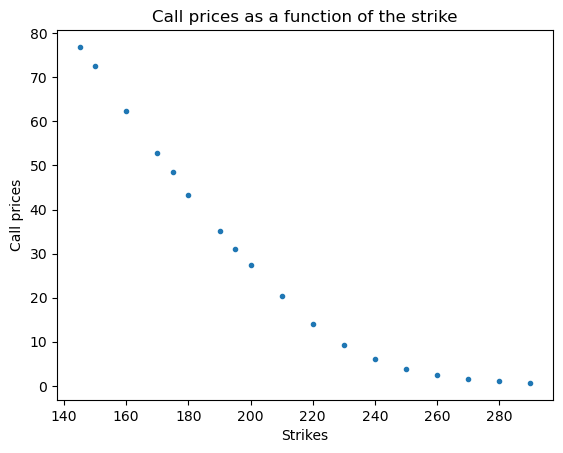

In [440]:
option_prices.iloc[5].plot(style='.')
plt.xlabel('Strikes')
plt.ylabel('Call prices')
plt.title('Call prices as a function of the strike')
plt.show()

We now want to build the risk-free rate. We will use the US treasury yield curve as a proxy of this risk-free rate (we could use LIBOR or other proxies)

In [441]:
risk_free=pd.DataFrame(index=[0,30,91,182,365,730,1825],columns=['r_t','Integrated value'])

In [442]:
risk_free['r_t']=[0.0483,0.0427,0.05187,0.0476,0.0419,0.03702,0.0331]
risk_free.iat[0,1]=0

In [443]:

for i in range(1,len(risk_free.index)):
    t_i=risk_free.index[i]/365
    t_im=risk_free.index[i-1]/365
    a=(risk_free.iat[i,0]-risk_free.iat[i-1,0])/(t_i-t_im)
    b=risk_free.iat[i,0]-a*t_i
    risk_free.iat[i,1]=a*(t_i)**2/2 + b*t_i - a*(t_im)**2/2 - b*t_im + risk_free.iat[i-1,1]

In [444]:
risk_free

,r_t,Integrated value
0,0.04830,0
30,0.04270,0.00374
91,0.05187,0.011642
182,0.04760,0.024042
365,0.04190,0.046478
730,0.03702,0.085938
1825,0.03310,0.191118


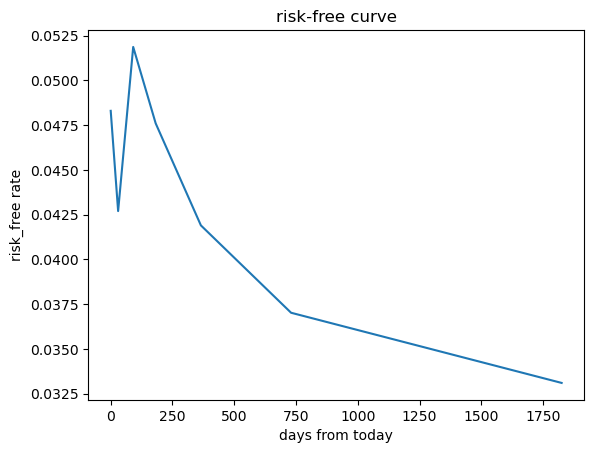

In [445]:
plt.plot(risk_free['r_t'])
plt.title("risk-free curve")
plt.xlabel('days from today')
plt.ylabel('risk_free rate')
plt.show()

In [446]:
f=sp.interpolate.interp1d(risk_free.index,risk_free['Integrated value'])

We can now write the discount function that we will use for the forward rate

In [447]:
def D(T):
    return np.exp(-f(T))

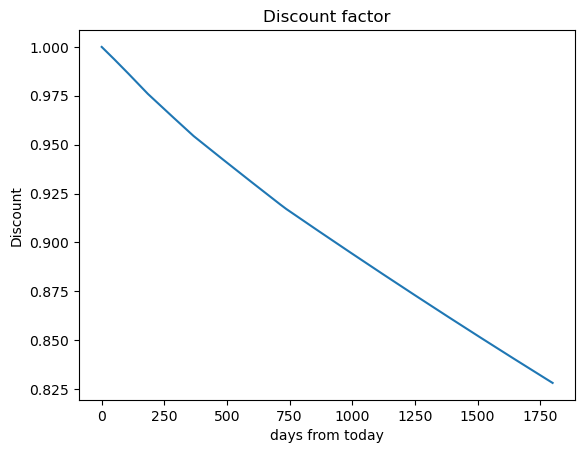

In [448]:
days=np.arange(0,1800)
plt.plot(days,D(days))
plt.title("Discount factor")
plt.xlabel('days from today')
plt.ylabel('Discount')
plt.show()

We deduce the ask-reference spread by dividing the difference (for ask) between last and ask prices by the forward rate and doing the same for the bid-reference spread

In [449]:
options_bid_norm=(option_prices-option_bid).apply(lambda x: x*D(x.index)/S, axis=0)
options_ask_norm=(option_ask-option_prices).apply(lambda x: x*D(x.index)/S, axis=0)

We can know deduce the normalized call prices c_i^j: we simply divide the call prices in the array by the corresponding forward price

In [450]:
options_prices_norm=option_prices.apply(lambda x: x*D(x.index)/S, axis=0)
options_prices_norm.insert(loc=0, column=0.0, value=[1]*len(options_prices_norm.index))

We create the dataframe of strikes divided by the forward price

In [451]:
strikes_norm=pd.DataFrame(index=maturities_frac,columns=strikes,data=[strikes for i in range(len(maturities_frac))])
strikes_norm=strikes_norm.apply(lambda x: x*D(x.index)/S, axis=0)
strikes_norm.insert(loc=0, column=0.0, value=[0.0]*len(options_prices_norm.index))

Let's display the original call surface as a function of the time expiry and the strikes

In [452]:
import matplotlib.pyplot as plt

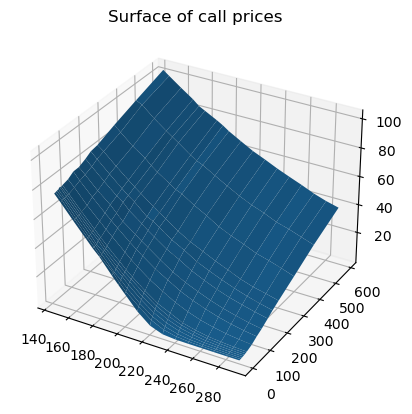

In [453]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Surface of call prices')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
plt.show()

We will now count the number of violations of static arbitrage as defined in the paper: we first define the function beta and the function S

Violation 1: outright violation

In [454]:
def v_1(df_prices):
    return np.sum(df_prices.iloc[:,-1:]<0).values[0]

In [455]:
%%timeit
v_1(options_prices_norm)

394 µs ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Violation 2: Vertical spread violation

In [456]:
def v_2_n(df_prices,df_strikes):
    df_prices_shift=df_prices.shift(-1,axis=1)
    df_strikes_shift=df_strikes.shift(-1,axis=1)
    arb_1=(df_prices-df_prices_shift)/(df_strikes-df_strikes_shift)
    return np.sum(np.sum(arb_1.iloc[:,1:]>0.01)) + np.sum(arb_1.iloc[:,0]<-1.01)

In [457]:
v_2_n(options_prices_norm,strikes_norm)

0

Violation 3: Vertical Butterfly violation

In [458]:
def v_3_n(df_prices,df_strikes):
    df1=(df_prices.shift(-1,axis=1)-df_prices)/(df_strikes.shift(-1,axis=1)-df_strikes)
    df2=-(df_prices.shift(1,axis=1)-df_prices)/(df_strikes.shift(1,axis=1)-df_strikes)
    df3=df1+df2
    return np.sum(np.sum(df3<-0.001))

In [459]:
v_3_n(options_prices_norm,strikes_norm)

63

Violation 4: Calendar spread

In [460]:
def v_4_n(df_prices,df_strikes):
    
    df_prices=df_prices.iloc[:,1:]
    df_strikes=df_strikes.iloc[:,1:]
    
    values = df_strikes.values.flatten()
    unique_values, counts = np.unique(values, return_counts=True)
    
    if all(counts == 1):
        return 0
    else:
        value_info = {}
        for value in unique_values:
            indices = np.argwhere(values == value)
            rows, cols = np.unravel_index(indices, df_strikes.shape)
            occurrences = len(indices)
            value_info[value] = (occurrences, rows, cols)
        number_of_violations=0
        for key in value_info.keys():
            if value_info[key][0]>1:
                for i in range(len(value_info[key][1])):
                    for j in range(i+1,len(value_info[key][1])):
                        if df_prices.iloc[value_info[key][1][i][0],value_info[key][2][i][0]]>df_prices.iloc[value_info[key][1][j][0],value_info[key][2][j][0]]:
                            number_of_violations+=1
            
        return number_of_violations

In [461]:
def v_4_n2(df_prices,df_strikes):
    
    number_of_violations=0
    for i in range(len(df_prices)-1):
        for j in range(len(df_prices.columns)):
            mask= (df_prices.iloc[i+1, j]< df_prices.iloc[i,j])
            number_of_violations+=mask
            if mask!=0:
                print(i,j)

            
    return number_of_violations

In [462]:
v_4_n2(option_prices,strikes_norm)

0 5
1 6
2 1
2 4
3 2
4 0
5 1


7

In [463]:
%%timeit
v_4_n2(options_prices_norm,strikes_norm)

0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
0 6
1 7


In [464]:
v_4_n(options_prices_norm,strikes_norm)

0

Violation 5: Calendar vertical spread

In [465]:
def create_index_dictionaryI(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):
        for j_star in range(1, n):
            key = (i_star, j_star)
            strikes_i_star_j_star = df_strikes.iloc[i_star, j_star - 1]
            strikes_i_star_j_star_plus_1 = df_strikes.iloc[i_star, j_star]


            mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_j_star) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_j_star_plus_1)
            
            indices = list(zip(*np.where(mask)))
            indices=[(i+i_star+1,j) for (i,j) in indices]
            index_dict[key] = indices

    return index_dict

In [466]:
def create_index_dictionaryI2(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):

        key = (i_star, n-1)
        strikes_i_star_n = df_strikes.iloc[i_star, n-1]
        mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_n) 
        indices = list(zip(*np.where(mask)))
        indices=[(i+i_star+1,j) for (i,j) in indices]

        index_dict[key] = indices

    return index_dict

In [467]:
def create_index_dictionaryI3(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):
        for j_star in range(n-1):
            key = (i_star, j_star)
            strikes_i_star_j_star = df_strikes.iloc[i_star, j_star ]
            strikes_i_star_j_star_plus_1 = df_strikes.iloc[i_star, j_star+1]


            mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_j_star) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_j_star_plus_1)
            
            indices = list(zip(*np.where(mask)))
            indices=[(i+i_star+1,j) for (i,j) in indices]
            index_dict[key] = indices
                

    return index_dict

In [468]:
def create_index_dictionaryI4(df_strikes):
    index_dict = {}
    m, n = df_strikes.shape

    for i_star in range(m):

        key = (i_star, n-1)
        strikes_i_star_n = df_strikes.iloc[i_star, n-1]
        strikes_i_star_n_minus_1 = df_strikes.iloc[i_star, n-2]
        
        mask = (df_strikes.iloc[i_star+1:, :] > strikes_i_star_n_minus_1) & (df_strikes.iloc[i_star+1:, :] < strikes_i_star_n)
            
        indices = list(zip(*np.where(mask)))
        indices=[(i+i_star+1,j) for (i,j) in indices]


        index_dict[key] = indices

    return index_dict

In [469]:
def v_5(df_prices,df_strikes):
    somme=0
    m=len(df_prices.index)
    n=len(df_prices.columns)
    for i_star in range(m):
        for j_star in range(1,n):
            for i in range(i_star+1,m):
                for j in range(1,n):
                    if df_strikes.iloc[i_star,j_star-1]<df_strikes.iloc[i,j]<df_strikes.iloc[i_star,j_star]:
                        if S_f(i_star,j_star,i,j,df_prices,df_strikes)<-0.0001:
                            somme+=1
    return somme

In [470]:
def v_5_n(df_prices,df_strikes):
    dictio=create_index_dictionaryI(df_strikes)
    number_of_violations=0
    for key in dictio.keys():
        kis_js=df_strikes.iloc[key]
        cis_js=df_prices.iloc[key]
        for elem2 in dictio[key]:
            ki_j=df_strikes.iloc[elem2]
            ci_j=df_prices.iloc[elem2]
            if -(cis_js - ci_j)/(kis_js- ki_j)<-0.0001:
                number_of_violations+=1 
    return number_of_violations

In [471]:
%%timeit
v_5_n(options_prices_norm,strikes_norm)

345 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [472]:
v_5_n(options_prices_norm,strikes_norm)

12

Violation 6.a: calendar butterfly I

In [473]:
def v_6_a_n(df_prices,df_strikes):
    dictioI1=create_index_dictionaryI(df_strikes)
    dictioI2=create_index_dictionaryI2(df_strikes)
    n,m=df_strikes.shape
    number_of_violations=0
    for key in dictioI1.keys():
        if key[1]!=m-1:
            kis_js=df_strikes.iloc[key]
            cis_js=df_prices.iloc[key]
            kis_js1=df_strikes.iloc[(key[0],key[1]+1)]
            cis_js1=df_prices.iloc[(key[0],key[1]+1)]
            
            for elem2 in dictioI1[key]:
                ki_j=df_strikes.iloc[elem2]
                ci_j=df_prices.iloc[elem2]
                if -(cis_js - ci_j)/(kis_js- ki_j) + (cis_js1 - cis_js)/(kis_js1- kis_js) <-0.001:
                    number_of_violations+=1 
    for key in dictioI1.keys():
        if key[1]>1:
            kis_jsm1=df_strikes.iloc[(key[0],key[1]-1)]
            cis_jsm1=df_prices.iloc[(key[0],key[1]-1)]
            kis_jsm2=df_strikes.iloc[(key[0],key[1]-2)]
            cis_jsm2=df_prices.iloc[(key[0],key[1]-2)]
            
            for elem2 in dictioI1[key]:
                ki_j=df_strikes.iloc[elem2]
                ci_j=df_prices.iloc[elem2]
                if -(cis_jsm1 - cis_jsm2)/(kis_jsm1- kis_jsm2) + (cis_jsm1 - ci_j)/(kis_jsm1- ki_j) <-0.001:
                    number_of_violations+=1 
    for key in dictioI2.keys():

        kis_jsm1=df_strikes.iloc[key]
        cis_jsm1=df_prices.iloc[key]
        kis_jsm2=df_strikes.iloc[(key[0],key[1]-1)]
        cis_jsm2=df_prices.iloc[(key[0],key[1]-1)]

        for elem2 in dictioI2[key]:
            ki_j=df_strikes.iloc[elem2]
            ci_j=df_prices.iloc[elem2]
            if -(cis_jsm1 - cis_jsm2)/(kis_jsm1- kis_jsm2) + (cis_jsm1 - ci_j)/(kis_jsm1- ki_j) <-0.001:
                number_of_violations+=1 

    return number_of_violations

In [474]:
v_6_a_n(options_prices_norm,strikes_norm)

66

Violation 6.b: calendar butterfly II

In [475]:
def v_6_b_n(df_prices,df_strikes):

    dictioI1=create_index_dictionaryI(df_strikes)
    dictioI2=create_index_dictionaryI2(df_strikes)
    dictioI3=create_index_dictionaryI3(df_strikes)
    dictioI4=create_index_dictionaryI4(df_strikes)

    n,m=df_strikes.shape
    number_of_violations=0
    for key in dictioI1.keys():
        if key[1]!=0 and key[1]!=m-1 :
            kis_js=df_strikes.iloc[key]
            cis_js=df_prices.iloc[key]
            for elem in dictioI1[key]:
                
                ki1_j1=df_strikes.iloc[elem]
                ci1_j1=df_prices.iloc[elem]

                for elem2 in dictioI3[key]:
                    ki2_j2=df_strikes.iloc[elem2]
                    ci2_j2=df_prices.iloc[elem2]
                    if -(cis_js - ci1_j1)/(kis_js- ki1_j1) + (cis_js - ci2_j2)/(kis_js- ki2_j2) <-0.0001:
                        number_of_violations+=1 

    for key in dictioI2.keys():

        kis_js=df_strikes.iloc[key]
        cis_js=df_prices.iloc[key]
        for elem in dictioI2[key]:

            ki1_j1=df_strikes.iloc[elem]
            ci1_j1=df_prices.iloc[elem]

            for elem2 in dictioI4[key]:
                ki2_j2=df_strikes.iloc[elem2]
                ci2_j2=df_prices.iloc[elem2]
                if -(cis_js - ci1_j1)/(kis_js- ki1_j1) + (cis_js - ci2_j2)/(kis_js- ki2_j2) <-0.0001:
                    number_of_violations+=1 

    return number_of_violations

In [476]:
v_6_b_n(options_prices_norm,strikes_norm)

200

We define a function that wraps up the latter functions

In [477]:
def n_violation_n(df_prices,df_strikes):
    v1,v2,v3,v4,v5=v_1(df_prices),v_2_n(df_prices,df_strikes),v_3_n(df_prices,df_strikes),v_4_n2(df_prices,df_strikes),v_5_n(df_prices,df_strikes)
    v6=v_6_a_n(df_prices,df_strikes)+v_6_b_n(df_prices,df_strikes)
    print("Number of outright violations: "+ str(v1))
    print("Number of vertical spread violations: "+ str(v2))
    print("Number of vertical butterfly violations: "+ str(v3))
    print("Number of calendar spread violations: "+ str(v4))
    print("Number of calendar vertical spread violations: "+ str(v5))
    print("Number of calendar butterfly violations: "+ str(v6))

In [478]:
n_violation_n(options_prices_norm,strikes_norm)

0 6
1 7
2 2
2 5
3 3
4 1
5 2
8 1
Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 63
Number of calendar spread violations: 8
Number of calendar vertical spread violations: 12
Number of calendar butterfly violations: 266


Now we can jump on the optimization problem: we will build the matrix A and the vector b of constraints as a list of list to pass them to the cvxopt module after. Having n_i=cst makes the construction easier

In [479]:
m=len(strikes_norm.index)
n=len(strikes_norm.columns)
N=n*m

We start with the first m rows that represent constraint 1:

In [480]:
A1=np.zeros((m,N))
for i in range(m):
    A1[i,(i+1)*n -1 ]=1
b1=np.zeros((m,1))

We now move on with constraint 2: one has to be careful with the 1st non 1 element of the prices tab:

In [481]:
A2=np.zeros((N,N))
np.fill_diagonal(A2, 1)
np.fill_diagonal(A2[:, 1:], -1)
A2 = np.delete(A2, [n*(i+1)-1 for i in range(m)], axis=0)
b2=np.zeros((N-m,1))

A2bis=np.zeros((m,N))
b2bis=np.zeros((m,1))
for i in range(m):
    A2bis[i,n*i]=1 
    b2bis[i]=1-strikes_norm.iloc[i,1]

We now attack constraint 3: as previously one must take some extra care with the first non 1 element of the prices tab

In [482]:
A3=np.zeros((N-2*m,N))

count=0
for i in range(m):
    for j in range(1,n-1):
        coeff_j_minus_1=1/(strikes_norm.iloc[i,j] - strikes_norm.iloc[i,j-1])
        coeff_j_plus_1=1/(strikes_norm.iloc[i,j] - strikes_norm.iloc[i,j+1])
        A3[count][i*n+j-1]=coeff_j_minus_1
        A3[count][i*n+j]=coeff_j_plus_1 -coeff_j_minus_1        
        A3[count][i*n+j+1]=-coeff_j_plus_1   
        count+=1
b3=np.zeros((N-2*m,1))

Now we move to constraint 4: here I dont see how it can be useful since strikes will always be different but w/e

In [483]:
for i1 in range(m):
    for i2 in range(i1+1,m):
        for j1 in range(n):
            for j2 in range(n):
                if strikes_norm.iloc[i1,j1+1]==strikes_norm.iloc[i2,j2+1]:
                    row=[0]*N
                    row[i1*n + j1]=-1
                    row[i2*n + j2]=1
                    A.append(row)
                    b.append(0)

IndexError: index 19 is out of bounds for axis 0 with size 19

We can now move to constraint 5

In [484]:
dictioI5=create_index_dictionaryI(strikes_norm)

In [485]:
s=sum(len(dictioI5[key]) for key in dictioI5.keys()) 
A5=np.zeros((s,N))
b5=np.zeros((s,1))
count=0
for key in dictioI5.keys():
    list_strikes=dictioI5[key]
    for x in list_strikes:
        A5[count,key[0]*n+ key[1]]=-1
        A5[count,x[0]*n+ x[1]]=1 
        count+=1 

Now constraint 6:a

In [486]:
dictio6a1=create_index_dictionaryI(strikes_norm)
dictio6a2=create_index_dictionaryI2(strikes_norm)

In [487]:
sa1=sum(len(dictio6a1[key]) for key in dictio6a1.keys() if key[1]!=n-1) 
A6a1=np.zeros((sa1,N))
count=0
for key in dictio6a1.keys():
    if key[1]!=n-1:
        list_strikes=dictio6a1[key]
        for x in list_strikes:
            den_i_j=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
            den_is_js_p1=1/(strikes_norm.iloc[key[0],key[1]+1]-strikes_norm.iloc[key])
            A6a1[count,key[0]*n+ key[1]]=-(den_i_j + den_is_js_p1)
            A6a1[count,x[0]*n+ x[1]]=den_i_j
            A6a1[count,key[0]*n+ key[1]+1]=den_is_js_p1 
            count+=1 
sa2=sum(len(dictio6a1[key]) for key in dictio6a1.keys() if key[1]>1) 
A6a2=np.zeros((sa2,N))
count=0
for key in dictio6a1.keys():
    if key[1]>1:
        list_strikes=dictio6a1[key]
        for x in list_strikes:
            den_is_js_m1=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[x])
            den_is_js_m2=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[key[0],key[1]-2])
            A6a2[count,key[0]*n+ key[1]-1]=den_is_js_m1 - den_is_js_m2
            A6a2[count,key[0]*n+ key[1]-2]=den_is_js_m2 
            A6a2[count,x[0]*n+ x[1]]=-den_is_js_m1
            count+=1 
sa3=sum(len(dictio6a2[key]) for key in dictio6a2.keys()) 
A6a3=np.zeros((sa3,N))
count=0
for key in dictio6a2.keys():

    list_strikes=dictio6a2[key]
    for x in list_strikes:
        den_i_j=1/(strikes_norm.iloc[key[0],key[1]-1]-strikes_norm.iloc[key])
        den_is_js_m1=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
        A6a3[count,key[0]*n+ key[1]-1]=den_i_j + den_is_js_p1
        A6a3[count,key[0]*n+ key[1]-2]=-den_i_j 
        A6a3[count,x[0]*n+ x[1]]=-den_is_js_p1
        count+=1 
b6a1=np.zeros((sa1,1))
b6a2=np.zeros((sa2,1))
b6a3=np.zeros((sa3,1))

And finally constraint 6.b

In [488]:
dictioI3=create_index_dictionaryI3(strikes_norm)
dictioI4=create_index_dictionaryI4(strikes_norm)

In [489]:
sa4=sum(len(dictio6a1[key])*len(dictioI3[key]) for key in dictio6a1.keys() if key[1]!=n-1) 
A6b1=np.zeros((sa4,N))
count=0
for key in dictio6a1.keys():
    if key[1]!=n-1:
        list_strikes1=dictio6a1[key]
        list_strikes2=dictioI3[key]
        for x in list_strikes1:
            for y in list_strikes2:
                den_i1_j1=1/(strikes_norm.iloc[key]-strikes_norm.iloc[x])
                den_i2_j2=1/(strikes_norm.iloc[key]-strikes_norm.iloc[y])
                A6b1[count,key[0]*n+ key[1]]=-den_i1_j1 + den_i2_j2
                A6b1[count,x[0]*n+ x[1]]=den_i1_j1
                A6b1[count,y[0]*n+ y[1]]=-den_i2_j2
                count+=1

sa5=sum(len(dictio6a2[key])*len(dictioI4[key]) for key in dictio6a2.keys()) 
A6b2=np.zeros((sa5,N))
count=0
for key in dictio6a2.keys():
    list_strikes1=dictio6a2[key]
    list_strikes2=dictioI4[key]
    for x in list_strikes1:
        for y in list_strikes2:
            den_i1_j1=1/(strikes_norm.iloc[x]-strikes_norm.iloc[key])
            den_i2_j2=1/(strikes_norm.iloc[key]-strikes_norm.iloc[y])
            A6b1[count,key[0]*n+ key[1]]=den_i1_j1 + den_i2_j2
            A6b1[count,x[0]*n+ x[1]]=-den_i1_j1
            A6b1[count,y[0]*n+ y[1]]=-den_i2_j2
            count+=1
            
b6b1=np.zeros((sa4,1))
b6b2=np.zeros((sa5,1))

Now, we create the vector c of option prices (excluding elements of the first column)

In [490]:
A_opt = np.vstack((A1, A2, A3, A5, A6a1,A6a2,A6b1,A6b2))

In [491]:
b_opt= np.vstack((b1, b2, b3, b5, b6a1,b6a2,b6b1,b6b2))

In [492]:
c=options_prices_norm.values.flatten()

We now move on the resolution of the system Ax>=b, with the quantities defined above, using the CVXOPT package and the GLPK solver

In [493]:
from cvxopt import matrix, solvers

We start with the l1 objective function

In [494]:
def l1(mat_A, vec_b, C, solver='glpk'):
    """
    Compute the perturbations needed to ensure arbitrage-free surface using
    the l1-norm objective.
    Minimise    ||epsilon||_l1
    s.t.        mat_A * (C + epsilon) >= vec_b
    Parameters
    ----------
    mat_A: 2D numpy.array, shape = (n_constraint, n_quote)
        The arbitrage-free constraint coefficient matrix.
    vec_b: 1D numpy.array, shape = (n_constraint,)
        The arbitrage-free constraint constant bound vector.
    C: 1D numpy.array, shape = (n_quote,)
        The call price vector.
    Returns
    -------
    epsilon: 1D numpy.array, shape = (n_quote, )
        The optimal perturbation vector, if the optimisation problem is
        solved successfully. Otherwise an empty list will be returned.
    """

    n_quote = mat_A.shape[1]
    MAX_ATTEMPTS = 8  # max number of attempts to solve the optimisation
    sol = []

    # Construct required quantities for the LP
    A = -np.hstack((mat_A, -mat_A))
    b = -(vec_b - mat_A.dot(C))
    coeff = np.ones(2 * n_quote)

    A1 = np.vstack((A, -np.diag(np.ones(2 * n_quote))))
    b1 = np.hstack((b, np.zeros(2 * n_quote)))
    G = matrix(A1)
    h = matrix(b1.astype(np.double))
    c = matrix(coeff)

    '''
    Scale the constraint for numerical stability
    A * (scale * epsilon) >= scale * b
    '''
    G *= 2.0
    h *= 2.0

    i_attempt = 1
    scale = .1
    status = 'initial'
    while status != 'optimal':
        scale *= 10
        c *= scale
        h *= scale

        # solve the LP
        sol = solvers.lp(c, G, h, solver=solver)
        status = sol['status']

        i_attempt += 1
        if i_attempt > MAX_ATTEMPTS:
            break

    if status == 'optimal':
        x = np.array(sol['x'])
        epsilon = x[:n_quote] - x[n_quote:]
        epsilon = epsilon.flatten()
        epsilon /= scale
    else:
        epsilon = []
        print('Optimal perturbation is not found after {} attempts!'.
              format(MAX_ATTEMPTS))

    return epsilon

In [495]:
#s is the optimal solution for the vector of perturbations
s=l1(A_opt,b_opt.flatten(),c, solver='glpk')

In [496]:
s

array([ 0.00000000e+00, -4.71068877e-04, -8.08428305e-04,  2.20431274e-04,
       -9.19407223e-20, -1.10215637e-04, -3.17330056e-03,  1.26996931e-04,
        3.57496981e-04,  2.47281344e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.39034650e-18,
       -1.80685773e-04, -2.88162952e-03,  0.00000000e+00,  2.71754296e-04,
        7.48049952e-04,  1.90518262e-03, -2.54217853e-03,  0.00000000e+00,
        2.72721812e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.01793368e-05,
       -3.08240485e-03, -1.84290391e-04,  6.73094550e-04, -8.08081388e-19,
       -1.06225239e-04,  1.26855835e-03, -1.46313727e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [497]:
s.shape

(304,)

In [498]:
x=c+s

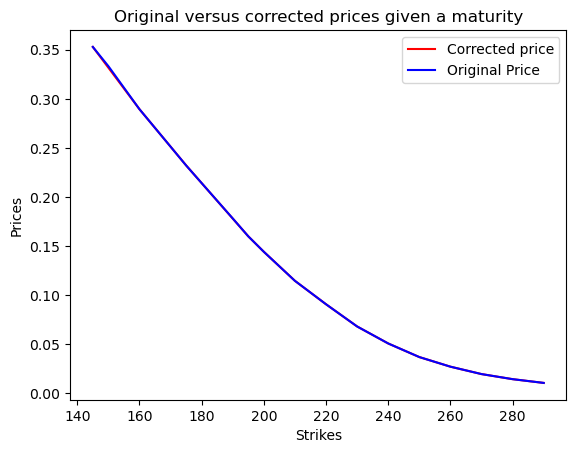

In [506]:
j=7
plt.plot(strikes_norm.columns[1:],x[n*j:n*j+n][1:],'r',label='Corrected price')
plt.plot(strikes_norm.columns[1:],c[n*j:n*j+n][1:],'b',label='Original Price')
plt.title('Original versus corrected prices given a maturity')
plt.legend(loc='best')
plt.xlabel('Strikes')
plt.ylabel('Prices')
plt.show()

As one can see, the difference is hardly visible with bare eyes so we plot the difference instead

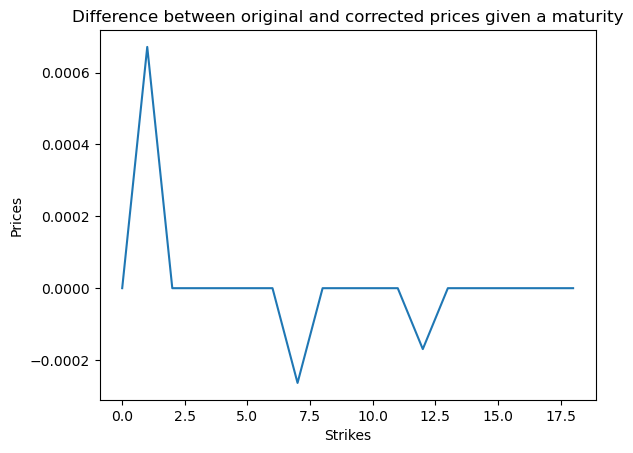

In [507]:
j=6
plt.plot(x[n*j:n*j+n]-c[n*j:n*j+n])
plt.title('Difference between original and corrected prices given a maturity')
plt.xlabel('Strikes')
plt.ylabel('Prices')
plt.show()

We now jump back to the original dimension of prices multiplying the price dataframe with the according forward (we divided before)

In [508]:
new_prices=pd.DataFrame(index=maturities_frac,columns=strikes_norm.columns,data=x.reshape((len(maturities_frac),len(strikes_norm.columns))))
new_prices_or=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)

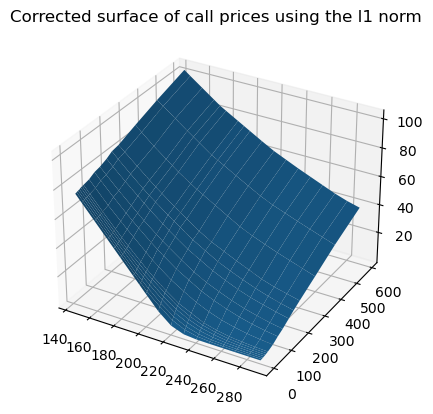

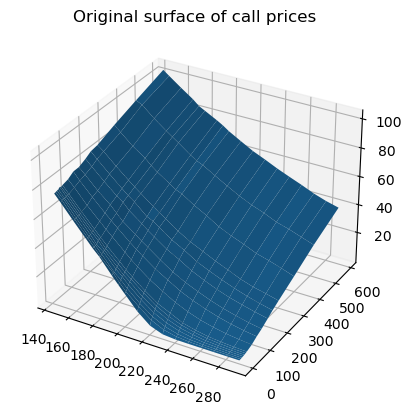

In [509]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Corrected surface of call prices using the l1 norm')
YY = new_prices_or.index
XX = new_prices_or.columns[1:]
XX, YY = np.meshgrid(XX, YY)
ZZ = new_prices_or.iloc[:,1:].values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Original surface of call prices')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
plt.show()

If the optimization made sense, we should not get any arbitrage in the resulting surface, so we check that

In [510]:
n_violation_n(new_prices,strikes_norm)

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0


We will now use the l1ba objective function to solve the problem

In [511]:
def l1ba(mat_A, vec_b, C, spread=None, solver='glpk'):
    """
    Compute the perturbations needed to ensure arbitrage-free surface.
    Minimise    f(epsilon; spreads)
    s.t.        mat_A * (C + epsilon) >= vec_b
    Parameters
    ----------
    mat_A: 2D numpy.array, shape = (n_constraint, n_quote)
        The arbitrage-free constraint coefficient matrix.
    vec_b: 1D numpy.array, shape = (n_constraint,)
        The arbitrage-free constraint constant bound vector.
    C: 1D numpy.array, shape = (n_quote,)
        The call price vector.
    spread: 1d numpy.array, shape = (n_quote,)
        The bid-ask spread vector.
    Returns
    -------
    epsilon: 1d numpy.array, shape = (n_quote, )
        The optimal perturbation vector, if the optimisation problem is
        solved successfully. Otherwise an empty list will be returned.
    """

    n_quote = mat_A.shape[1]
    MAX_ATTEMPTS = 2  # max number of attempts to solve the optimisation
    sol = []

    if spread is None:
        print('No spread data have been provided, so the l1-norm objecitve is '
              'used automatically.')
        return l1(mat_A, vec_b, C)
    else:
        try:
            delta_ask = spread[0]
            delta_bid = spread[1]
            delta0 = np.min([np.min(delta_ask), np.min(delta_bid)])
            delta0 = 1./len(delta_ask) if delta0 > 1./len(delta_ask) else delta0
            delta0 = 1e-8 if delta0 < 1e-8 else delta0
        except ValueError:
            raise  ValueError('Please ensure that the spread input has legal '
                              'format! It should contain two arrays/lists, one '
                              'for bid-reference spread, one for ask-reference '
                              'spread.')

        # Construct required quantities for the LP
        I = np.eye(n_quote)
        B2_bid = np.diag(delta_bid) / delta0
        B2_ask = np.diag(delta_ask) / delta0
        O = np.zeros([mat_A.shape[0], n_quote])
        B = np.block([
            [-I, -I],
            [I, -I],
            [-I, -B2_bid],
            [I, -B2_ask],
            [-mat_A, O]
        ])
        d = np.hstack([delta_bid - delta0,
                        delta_ask - delta0,
                        np.zeros(2 * n_quote),
                        -vec_b + mat_A.dot(C)])
        coeff = np.hstack([np.zeros(n_quote), np.ones(n_quote)])

        G = matrix(B)
        h = matrix(d.astype(np.double))
        c = matrix(coeff)

        '''
        Scale the constraint for numerical stability
        A * (scale * epsilon) >= scale * b
        '''
        i_attempt = 1
        scale = .1
        status = 'initial'
        while status != 'optimal':
            scale *= 10
            c *= scale
            h *= scale

            # Solve the LP
            sol = solvers.lp(c, G, h, solver=solver)
            status = sol['status']

            i_attempt += 1
            if i_attempt > MAX_ATTEMPTS:
                break

        if status == 'optimal':
            epsilon = np.array(sol['x'])[:n_quote]
            epsilon = epsilon.flatten()
            epsilon /= scale
        else:
            epsilon = []
            print('Optimal perturbation is not found after {} attempts!'.
                  format(MAX_ATTEMPTS))

    return epsilon

We need to pass the ask and bid reference spread to the function as a list of list

In [512]:
ask_ref=options_ask_norm.values.flatten().astype(np.double)
bid_ref=options_bid_norm.values.flatten().astype(np.double)

In [513]:
options_bid_norm

,145.0,150.0,160.0,170.0,175.0,180.0,190.0,195.0,200.0,210.0,220.0,230.0,240.0,250.0,260.0,270.0,280.0,290.0
2,0.001476,0.001931,0.00159,0.00159,0.001817,0.00159,0.001476,0.000909,0.000454,0.000341,0.000227,0.000023,0.000023,0.000023,0.000023,0.000045,0.000023,0.000023
9,0.001702,0.001816,0.001702,0.001475,0.001589,0.001702,0.001021,0.000567,0.000794,0.000681,0.000227,0.000113,0.000045,0.000023,0.000023,0.000023,0.000023,0.000023
16,0.002381,0.002267,0.002608,0.002494,0.002494,0.001701,0.00102,0.000907,0.00068,0.000907,0.000227,0.000227,0.000091,0.000045,0.000023,0.000045,0.000023,0.000023
23,0.002945,0.002492,0.002492,0.001812,0.002152,0.001359,0.000906,0.000906,0.000793,0.00068,0.000227,0.000227,0.000227,0.000091,0.000068,0.000045,0.000045,0.000045
30,0.003961,0.002603,0.003508,0.003169,0.003169,0.001132,0.001132,0.001132,0.001132,0.001245,0.000226,0.00034,0.000226,0.000136,0.000091,0.000068,0.000068,0.000045
37,0.002261,0.00147,0.001583,0.001131,0.001131,0.001131,0.001244,0.000792,0.000905,0.000678,0.000226,0.000226,0.000226,0.000226,0.000068,0.000045,0.000045,0.000023
44,0.006665,0.006665,0.006326,0.002824,0.002824,0.002711,0.002146,0.002372,0.002485,0.002824,0.000678,0.000565,0.000339,0.000452,0.000362,0.000226,0.000226,0.000203
72,0.002364,0.001914,0.001013,0.0009,0.0009,0.000675,0.000675,0.000675,0.001126,0.000788,0.000338,0.000225,0.000225,0.000338,0.000225,0.000113,0.000113,0.000068
100,0.002019,0.001234,0.00157,0.00157,0.001346,0.001346,0.001346,0.001346,0.000897,0.000449,0.000336,0.000336,0.000336,0.000224,0.000224,0.000224,0.000224,0.000224
128,0.002011,0.001452,0.001564,0.001899,0.002011,0.001676,0.001788,0.001676,0.001341,0.001788,0.000894,0.000335,0.000335,0.000335,0.000223,0.000223,0.000223,0.000223


In [ ]:
x=c+s
new_prices_ba=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
new_prices_or_ba=new_prices_ba.apply(lambda x: x/D(x.index)*S, axis=0)

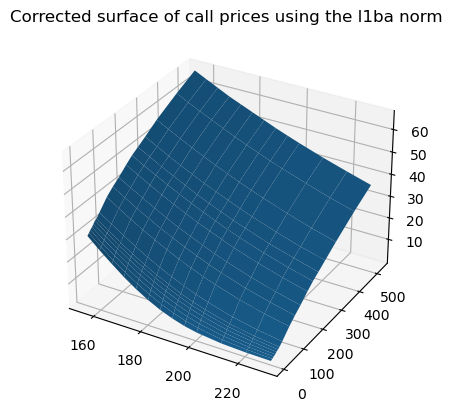

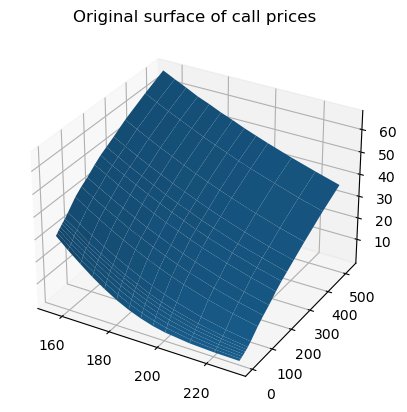

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Corrected surface of call prices using the l1ba norm')
YY = new_prices_or_ba.index
XX = new_prices_or_ba.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = new_prices_or_ba.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Original surface of call prices')
YY = option_prices.index
XX = option_prices.columns
XX, YY = np.meshgrid(XX, YY)
ZZ = option_prices.values
surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
plt.show()

# Part 2: We rewrite the first part as a function, to make the user only enter a non-dividend stock ticker

In [ ]:
def Repair(ticker,norm="l1"):


    today= datetime.today()
    S=si.get_live_price(ticker)
    maturities = options.get_expiration_dates(ticker)
    maturities_frac=[]
    for x in maturities:
        maturities_frac.append((datetime.strptime(x, "%B %d, %Y")-today).days+1)

    chain = options.get_options_chain(ticker,maturities[-1])
    calls = chain["calls"]
    strikes=calls["Strike"]
    for i in range(len(maturities)-1,-1,-1):
        chain = options.get_options_chain(ticker,maturities[i])
        calls_n = chain["calls"]
        strikes=set(strikes).intersection(set(calls_n["Strike"]))
        strikes=list(strikes)

    strikes.sort()

    option_prices=pd.DataFrame(index=maturities_frac,columns=strikes)
    option_bid=pd.DataFrame(index=maturities_frac,columns=strikes)
    option_ask=pd.DataFrame(index=maturities_frac,columns=strikes)

    for i in range(len(maturities)):
        chain = options.get_options_chain(ticker,maturities[i])
        calls_n = chain["calls"]
        calls_n=calls_n[calls_n['Strike'].isin(strikes)]
        option_prices.iloc[i]=(calls_n["Bid"]+calls_n["Ask"])/2
        option_bid.iloc[i]=calls_n["Bid"]
        option_ask.iloc[i]=calls_n["Ask"]

    risk_free=pd.DataFrame(index=[0,30,91,182,365,730,1825],columns=['r_t','Integrated value'])
    risk_free['r_t']=[0.0483,0.0450,0.0484,0.0476,0.0419,0.03702,0.0331]
    risk_free.iat[0,1]=0

    for i in range(1,len(risk_free.index)):
        t_i=risk_free.index[i]/365
        t_im=risk_free.index[i-1]/365
        a=(risk_free.iat[i,0]-risk_free.iat[i-1,0])/(t_i-t_im)
        b=risk_free.iat[i,0]-a*t_i
        risk_free.iat[i,1]=a*(t_i)**2/2 + b*t_i - a*(t_im)**2/2 - b*t_im + risk_free.iat[i-1,1]

    f=sp.interpolate.interp1d(risk_free.index,risk_free['Integrated value'])
    def D(T):
        return np.exp(-f(T))

    options_bid_norm=(option_prices-option_bid).apply(lambda x: x*D(x.index)/S, axis=0)
    options_ask_norm=(option_ask-option_prices).apply(lambda x: x*D(x.index)/S, axis=0)
    options_prices_norm=option_prices.apply(lambda x: x*D(x.index)/S, axis=0)
    options_prices_norm.insert(loc=0, column=0.0, value=[1]*len(options_prices_norm.index))

    strikes_norm=pd.DataFrame(index=maturities_frac,columns=strikes,data=[strikes for i in range(len(maturities))])
    strikes_norm=strikes_norm.apply(lambda x: x*D(x.index)/S, axis=0)
    strikes_norm.insert(loc=0, column=0.0, value=[0.0]*len(options_prices_norm.index))
    print("Before repair, we get those arbitrages: \n")
    n_violation(options_prices_norm,strikes_norm)
    print("\n")
    A=[]
    b=[]
    n=len(strikes_norm.columns)-1
    m=len(strikes_norm.index)
    N=n*m

    for i in range(m):
        row=[0]*N
        row[(i+1)*n-1]=1
        A.append(row)
        b.append(0)

    for i in range(N):
        if i%n==0:
            row=[0]*N
            row[i]=-1
            A.append(row)
            b.append(-1)
        else:
            row=[0]*N
            row[i]=-1
            row[i-1]=1
            A.append(row)
            b.append(0)

    for i in range(m):
        row=[0]*N
        row[i*n]=1
        A.append(row)
        b.append(1-strikes_norm.iloc[i,1])

    for i in range(N):
        if i%n==0:
            index_m=i//n
            index_s=i%n
            row=[0]*N
            row[i]=-1/(strikes_norm.iloc[index_m,index_s+2]-strikes_norm.iloc[index_m,index_s+1])-1/strikes_norm.iloc[index_m,index_s+1]
            row[i+1]=1/(strikes_norm.iloc[index_m,index_s+2]-strikes_norm.iloc[index_m,index_s+1])
            A.append(row)
            b.append(-1/strikes_norm.iloc[index_m,index_s+1])
        elif (i+1)%n==0:
            pass
        else:

            index_m=i//n
            index_s=i%n
            row=[0]*N
            row[i-1]=1/(strikes_norm.iloc[index_m,index_s+1]-strikes_norm.iloc[index_m,index_s])
            row[i]=-1/(strikes_norm.iloc[index_m,index_s+1]-strikes_norm.iloc[index_m,index_s]) - 1/(strikes_norm.iloc[index_m,index_s+2]-strikes_norm.iloc[index_m,index_s+1])
            row[i+1]=1/(strikes_norm.iloc[index_m,index_s+2]-strikes_norm.iloc[index_m,index_s+1])
            A.append(row)
            b.append(0)
    for i1 in range(m):
        for i2 in range(i1+1,m):
            for j1 in range(n):
                for j2 in range(n):
                    if strikes_norm.iloc[i1,j1+1]==strikes_norm.iloc[i2,j2+1]:
                        row=[0]*N
                        row[i1*n + j1]=-1
                        row[i2*n + j2]=1
                        A.append(row)
                        b.append(0)

    for i_star in range(m):
        for j_star in range(n):
            for i in range(i_star+1,m):
                for j in range(n):
                    if strikes_norm.iloc[i_star,j_star]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_star,j_star+1]:
                        row=[0]*N
                        row[i_star*n + j_star]=-1
                        row[i*n + j]=1
                        A.append(row)
                        b.append(0)

    for i_star in range(m):
        for j_star in range(n-1):
            for i in range(i_star+1,m):
                for j in range(n):
                    if strikes_norm.iloc[i_star,j_star]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_star,j_star+1]:
                        row=[0]*N
                        row[i_star*n + j_star]=-1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[i,j+1]) - 1/(strikes_norm.iloc[i_star,j_star+2]-strikes_norm.iloc[i_star,j_star+1])
                        row[i_star*n + j_star+1]=1/(strikes_norm.iloc[i_star,j_star+2]-strikes_norm.iloc[i_star,j_star+1])
                        row[i*n + j]=1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[i,j+1])
                        A.append(row)
                        b.append(0)

    for i_s in range(m):
            for j_s in range(2,n):
                for i in range(i_s+1,m):
                    for j in range(1,n):
                        if strikes_norm.iloc[i_s,j_s]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_s,j_s+1]:

                            row=[0]*N
                            row[i_s*n + j_s-1]=-1/(strikes_norm.iloc[i_s,j_s]-strikes_norm.iloc[i_s,j_s-1]) - 1/(strikes_norm.iloc[i,j+1]-strikes_norm.iloc[i_s,j_s])
                            row[i_s*n + j_s-2]=1/(strikes_norm.iloc[i_s,j_s]-strikes_norm.iloc[i_s,j_s-1])
                            row[i*n + j]=1/(strikes_norm.iloc[i,j+1]-strikes_norm.iloc[i_s,j_s])
                            A.append(row)
                            b.append(0)

    for i_star in range(m):
            for i in range(i_star+1,m):
                    for j in range(n):
                        if strikes_norm.iloc[i_star,-1]<strikes_norm.iloc[i,j+1]:
                            row=[0]*N
                            row[i_star*n + n-1]=-1/(strikes_norm.iloc[i_star,-1]-strikes_norm.iloc[i_star,-2]) - 1/(strikes_norm.iloc[i,j+1]-strikes_norm.iloc[i_star,-1])
                            row[i_star*n + n-2]=1/(strikes_norm.iloc[i_star,-1]-strikes_norm.iloc[i_star,-2])
                            row[i*n + j]=1/(strikes_norm.iloc[i,j+1]-strikes_norm.iloc[i_star,-1])
                            A.append(row)
                            b.append(0)

    for i_star in range(m):
        for j_star in range(n-1):
            I1=[]
            I2=[]
            for i in range(i_star+1,m):
                for j in range(n):
                    if strikes_norm.iloc[i_star,j_star]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_star,j_star+1]:
                        I1.append((i,j))
                    if strikes_norm.iloc[i_star,j_star+1]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_star,j_star+2]:
                        I2.append((i,j))
            for elem1 in I1:
                for elem2 in I2:
                    row=[0]*N
                    row[i_star*n + j_star]=-1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[elem1[0],elem1[1]+1]) - 1/(strikes_norm.iloc[elem2[0],elem2[1]+1]-strikes_norm.iloc[i_star,j_star+1])
                    row[elem1[0]*n + elem1[1]]=1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[elem1[0],elem1[1]+1])
                    row[elem2[0]*n + elem2[1]]=1/(strikes_norm.iloc[elem2[0],elem2[1]+1]-strikes_norm.iloc[i_star,j_star+1])
                    A.append(row)
                    b.append(0)


    for i_star in range(m):
            I1=[]
            I2=[]
            for i in range(i_star+1,m):
                    for j in range(1,n):
                        if strikes_norm.iloc[i_star,-2]<strikes_norm.iloc[i,j+1]<strikes_norm.iloc[i_star,-1]:
                            I1.append((i,j))
                        if strikes_norm.iloc[i_star,n-1]<strikes_norm.iloc[i,j+1]:
                            I2.append((i,j))
            for elem1 in I1:
                    for elem2 in I2:
                        row=[0]*N
                        row[i_star*n + j_star]=-1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[elem1[0],elem1[1]+1]) - 1/(strikes_norm.iloc[elem2[0],elem2[1]+1]-strikes_norm.iloc[i_star,j_star+1])
                        row[i1*n + j1]=1/(strikes_norm.iloc[i_star,j_star+1]-strikes_norm.iloc[elem1[0],elem1[1]+1])
                        row[i2*n + j2]=1/(strikes_norm.iloc[elem2[0],elem2[1]+1]-strikes_norm.iloc[i_star,j_star+1])
                        A.append(row)
                        b.append(0)

    c=options_prices_norm.iloc[:,1:].values.flatten()

    if norm=="l1":
        A_n=np.array(A)
        b_n=np.array(b)
        s=l1(A_n,b,c, solver='glpk')
        x=c+s
        new_prices=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
        new_prices_or=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)
        new_prices.insert(loc=0, column=0.0, value=[1.0]*len(options_prices_norm.index))
        print("After repair, we get those arbitrages: \n")
        n_violation(new_prices,strikes_norm)
        print("\n")
        return s,new_prices_or
    elif norm=="l1ba":
        ask_ref=options_ask_norm.values.flatten().astype(np.double)
        bid_ref=options_bid_norm.values.flatten().astype(np.double)
        A_n=np.array(A)
        b_n=np.array(b)
        s=l1ba(A_n, b_n, c, spread=[ask_ref,bid_ref], solver='glpk')
        x=c+s
        new_prices=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
        new_prices_or=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)
        new_prices.insert(loc=0, column=0.0, value=[1.0]*len(options_prices_norm.index))
        print("After repair, we get those arbitrages: \n")
        n_violation(new_prices,strikes_norm)
        print("\n")
        return s,new_prices_or
    else:
        A_n=np.array(A)
        b_n=np.array(b)
        s_ba=l1(A_n,b,c, solver='glpk')
        x=c+s_ba
        new_prices=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
        new_prices_or_ba=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)
        new_prices.insert(loc=0, column=0.0, value=[1.0]*len(options_prices_norm.index))
        print("After repair with l1 norm, we get those arbitrages: \n")
        n_violation(new_prices,strikes_norm)
        print("\n")
        ask_ref=options_ask_norm.values.flatten().astype(np.double)
        bid_ref=options_bid_norm.values.flatten().astype(np.double)
        s=l1ba(A_n, b_n, c, spread=[ask_ref,bid_ref], solver='glpk')
        x=c+s
        new_prices=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
        new_prices_or=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)
        new_prices.insert(loc=0, column=0.0, value=[1.0]*len(options_prices_norm.index))
        print("After repair with l1ba norm, we get those arbitrages: \n")
        n_violation(new_prices,strikes_norm)
        print("\n")
        return s,s_ba,new_prices_or,new_prices_or_ba

In [ ]:
corr,corr_ba,p,p_ba=Repair("TSLA","both")

# Part 3: we add noise to the original call price surface to stress-test the repair method

In [ ]:
def stress_test(A,b,ticker,arb_free_prices,lda,sigma,norm='l1',spread=None,compute_violations=False):
    """
    Add perturbation to the arb-free surface and make it arbitrage free again.
    Minimise    f(epsilon; spreads)
    s.t.        A * (arb_free_prices + epsilon + noise) >= vec_b
    Parameters
    ----------
    A: 2D numpy.array, shape = (n_constraint, n_quote)
        The arbitrage-free constraint coefficient matrix.
    b: 1D numpy.array, shape = (n_constraint,)
        The arbitrage-free constraint constant bound vector.
    arb_free_prices: 1D numpy.array, shape = (n_quote,)
        The call price vector.
    lda: float in [0,1]
        The proportion of perturbed prices in the arbitrage-free
        surface
    sigma: positive float
        The standard deviation used to generate the gaussian noise
    norm: string equal to 'l1' for l1 norm else change
        The norm used for stress testing
    spread: 1d numpy.array, shape = (n_quote,)
        The bid-ask spread vector.
    Returns
    -------
    s: 1d numpy.array, shape = (n_quote, )
        The optimal perturbation vector, if the optimisation problem is
        solved successfully. Otherwise an empty list will be returned.
    new_prices: 2d numpy.array, shape = (n_maturities, n_strikes)
        The new dataframe of prices obtained after making the surface
        arbitrage free again
    lda_exp: The proportion of perturbed prices comparing the initial
        and final arbitrage free surfaces
    """
    if norm!='l1' and spread==None:
        norm='l1'
        print('No spread passed default back to l1 norm')
    if arb_free_prices.columns[0]==0.0:
        arb_free_prices=arb_free_prices.iloc[:,1:]


    today= datetime.today()
    S=si.get_live_price(ticker)
    backup=arb_free_prices.apply(lambda x: x*D(x.index)/S, axis=0).values.flatten()
    maturities = options.get_expiration_dates(ticker)
    maturities_frac=[]
    for x in maturities:
        maturities_frac.append((datetime.strptime(x, "%B %d, %Y")-today).days+1)
    maturities_frac=maturities_frac[:-3]
    N=len(arb_free_prices.values.flatten())

    strikes= np.array(arb_free_prices.columns)
    strikes_norm=pd.DataFrame(index=maturities_frac,columns=strikes,data=[strikes for i in range(len(maturities_frac))])
    strikes_norm=strikes_norm.apply(lambda x: x*D(x.index)/S, axis=0)
    strikes_norm.insert(loc=0, column=0.0, value=[0.0]*len(strikes_norm.index))
    n_perturbation=int(lda*N)
    x=np.zeros(N)
    positions=np.random.choice(np.arange(N), n_perturbation, replace=False)
    x[positions]=np.random.normal(0,sigma,n_perturbation)
    x=np.exp(x)

    arb_free_prices=pd.DataFrame(index=arb_free_prices.index,columns=strikes,data=(arb_free_prices.values.flatten()*x).reshape((len(arb_free_prices.index),len(arb_free_prices.columns))))



    options_prices_norm=arb_free_prices.apply(lambda x: x*D(x.index)/S, axis=0)
    options_prices_norm.insert(loc=0, column=0.0, value=[1]*len(options_prices_norm.index))

    if compute_violations:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.set_title('Perturbed surface of call price with gaussian noise')
        YY = arb_free_prices.index
        XX = arb_free_prices.columns
        XX, YY = np.meshgrid(XX, YY)
        ZZ = arb_free_prices.values
        surf = ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1)
        plt.show()
        print("Before repair, we get those arbitrages: \n")

        n_violation(options_prices_norm,strikes_norm)

        print("\n")

    c=options_prices_norm.iloc[:,1:].values.flatten()

    A_n=np.array(A)
    b_n=np.array(b)
    if norm=='l1':
        s=l1(A_n,b,c, solver='glpk')
    else:
        s=l1ba(A_n, b, c, spread, solver='glpk')
    x=c+s
    new_prices=pd.DataFrame(index=maturities_frac,columns=strikes,data=x.reshape((len(maturities_frac),len(strikes))))
    lda_exp=1/N *np.sum([new_prices.values.flatten()[i]!=backup[i] for i in range(len(backup))])
    new_prices_or=new_prices.apply(lambda x: x/D(x.index)*S, axis=0)
    new_prices.insert(loc=0, column=0.0, value=[1.0]*len(options_prices_norm.index))
    if compute_violations:
        print("After repair, we get those arbitrages: \n")
        n_violation(new_prices,strikes_norm)
        print("\n")

    return s,new_prices_or,lda_exp



Below is an example on how one can use the latter function to stress-test the repair method

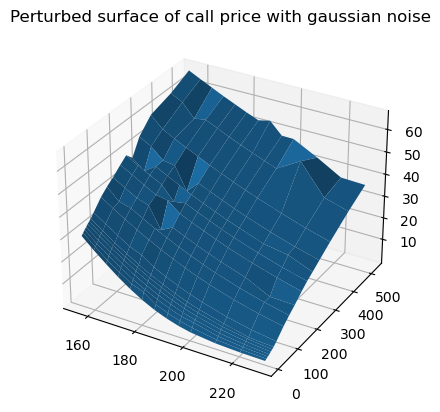

Before repair, we get those arbitrages: 

Number of outright violations: 0
Number of vertical spread violations: 7
Number of vertical butterfly violations: 23
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 13
Number of calendar butterfly violations: 70


After repair, we get those arbitrages: 

Number of outright violations: 0
Number of vertical spread violations: 0
Number of vertical butterfly violations: 0
Number of calendar spread violations: 0
Number of calendar vertical spread violations: 0
Number of calendar butterfly violations: 0




In [ ]:
st,pr,lda_exp=stress_test(A_n,b_n,"TSLA",new_prices_or,0.1,0.1,'l1',spread=[ask_ref,bid_ref],compute_violations=True)

The function below is used to compute an average of the number of perturbed prices and the average fail rate of the algorithm for the chosen noise

In [ ]:
def stats_stress(A_n,b_n,ticker,arb_free_price,lda,sigma,number_of_success,norm='l1',spread=None):
    s=0
    i=0
    number_of_trials=0
    while i<number_of_success:
        print(number_of_trials)
        number_of_trials=+1
        try:
            st,pr,lda_exp=stress_test(A_n,b_n,ticker,arb_free_price,lda,sigma,norm,spread,False)
            i+=1
            s+=lda_exp
        except:
            pass

    return s/number_of_success,number_of_success/number_of_trials